In [ ]:
!pip install medmnist

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [3]:
data_flag = 'dermamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: C:\Users\matia\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapo

In [6]:
# visualization

train_dataset.montage(length=1)

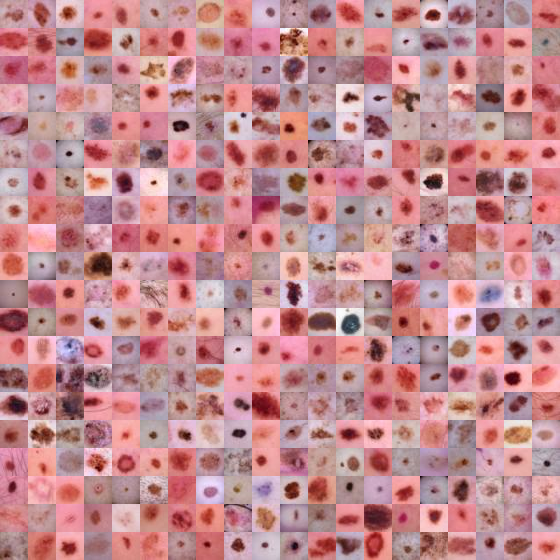

In [7]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [8]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [9]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 55/55 [00:07<00:00,  7.43it/s]


In [10]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.810  acc:0.670
test  auc: 0.804  acc:0.669


# We then check a 2D dataset with size 224x224

In [163]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[.5], std=[.5])
])

In [220]:

#Load training and test data

data_flag = 'dermamnist'
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
val_dataset =  DataClass(split='val', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=224, mmap_mode='r')



# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False) #False, will not train the model
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist_224.npz
Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist_224.npz
Using downloaded and verified file: C:\Users\matia\.medmnist\dermamnist_224.npz


In [180]:
#HSV feature extraction
from skimage.color import rgb2hsv

num_classes = 7

def hsv_feature(dataset):

    hsv_feature_matrix = []

    class_hue_hists = np.zeros((num_classes, 256))
    class_sat_hists = np.zeros((num_classes, 256))
    class_val_hists = np.zeros((num_classes, 256))
    num_points_in_class = np.zeros((num_classes,1))


    for i in tqdm(range(len(dataset))):
        x, y = dataset[i]
        x_numpy = x.numpy()  # Convert tensor to numpy array
        class_idx = y.item()
        """
        # Rescale the pixel values from [-1, 1] to [0, 1], since the DataClass is initialized with values in [-1,1]
        x_rescaled = (x_numpy + 1) / 2.0
        """
        x_numpy = np.transpose(x_numpy, (1, 2, 0))  # Convert to [H, W, C] for skimage
        
        # Convert the RGB image to HSV using skimage
        hsv_img = rgb2hsv(x_numpy) #returns normalized values in [0, 1] for H,S,V

        #make feature vector:
        # Make all values between 0-255 to make bins in histogram
        hue_values = hsv_img[:, :, 0] * 255 
        sat_values = hsv_img[:, :, 1] * 255
        val_values = hsv_img[:, :, 2] * 255

        # Now calculate histograms for each channel
        hue_hist, _ = np.histogram(hue_values, bins=np.arange(257))
        sat_hist, _ = np.histogram(sat_values, bins=np.arange(257))
        val_hist, _ = np.histogram(val_values, bins=np.arange(257))

        # Concatenate histograms to form a feature vector
        hsv_feature_vector = np.concatenate((hue_hist, sat_hist, val_hist)) 
        hsv_feature_matrix.append(hsv_feature_vector)

        # For the plotting, get a density array and keep track of histogram for each class

        class_hue_hists[class_idx] += hue_hist/(224*224)
        class_sat_hists[class_idx] += sat_hist/(224*224)
        class_val_hists[class_idx] += val_hist/(224*224)
        num_points_in_class[class_idx] += 1
    hsv_feature_matrix = np.array(hsv_feature_matrix) #feature vector, shape (7007, 765)

    class_hue_hists /= num_points_in_class
    class_sat_hists /= num_points_in_class
    class_val_hists /= num_points_in_class
    
    return hsv_feature_matrix, class_hue_hists, class_sat_hists, class_val_hists


In [181]:
#Do HSV feature extraction on train data

hsv_feature_matrix, class_hue_hists, class_sat_hists, class_val_hists = hsv_feature(train_dataset)

100%|██████████| 7007/7007 [02:30<00:00, 46.45it/s]


In [218]:
print(hsv_feature_matrix.shape)
print(class_hue_hists.shape)

(7007, 768)
(7, 256)
tensor([[[0.9059, 0.9176, 0.9176,  ..., 0.9216, 0.9176, 0.9137],
         [0.9176, 0.9216, 0.9176,  ..., 0.9176, 0.9137, 0.9098],
         [0.9098, 0.9176, 0.9137,  ..., 0.9137, 0.9098, 0.9059],
         ...,
         [0.8706, 0.8706, 0.8588,  ..., 0.8510, 0.8431, 0.8353],
         [0.8627, 0.8588, 0.8510,  ..., 0.8510, 0.8431, 0.8353],
         [0.8549, 0.8510, 0.8471,  ..., 0.8392, 0.8353, 0.8235]],

        [[0.5608, 0.5765, 0.5765,  ..., 0.5843, 0.5804, 0.5804],
         [0.5647, 0.5765, 0.5804,  ..., 0.5804, 0.5843, 0.5804],
         [0.5608, 0.5765, 0.5804,  ..., 0.5804, 0.5882, 0.5843],
         ...,
         [0.5725, 0.5686, 0.5569,  ..., 0.5373, 0.5333, 0.5294],
         [0.5725, 0.5608, 0.5490,  ..., 0.5412, 0.5333, 0.5255],
         [0.5647, 0.5569, 0.5529,  ..., 0.5412, 0.5412, 0.5373]],

        [[0.5725, 0.5804, 0.5882,  ..., 0.6000, 0.6000, 0.5843],
         [0.5882, 0.6000, 0.6000,  ..., 0.6000, 0.6000, 0.5922],
         [0.5922, 0.6039, 0.5961,  ..

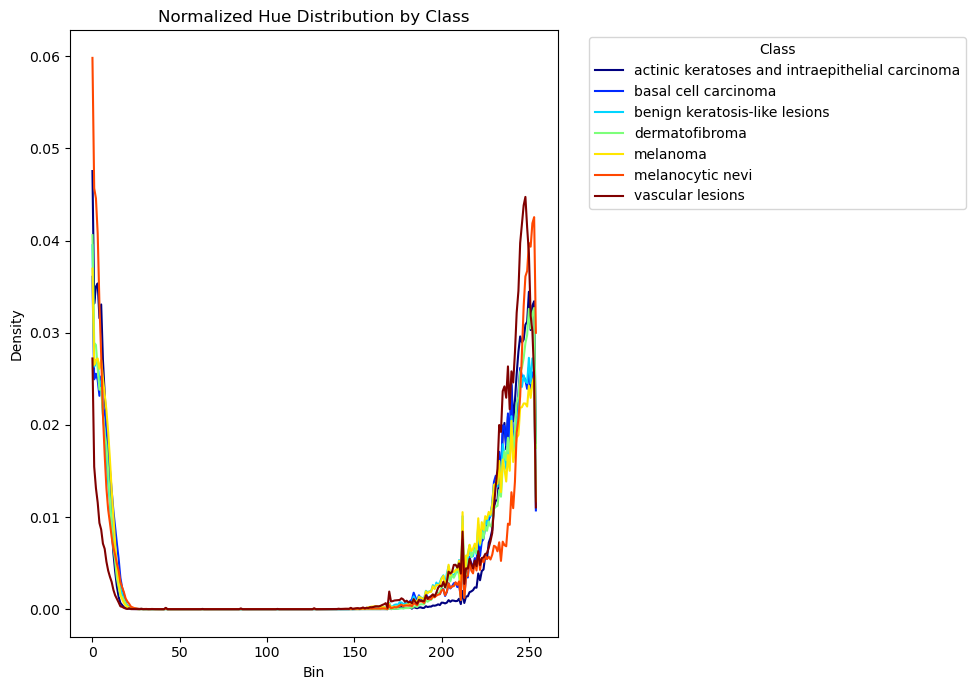

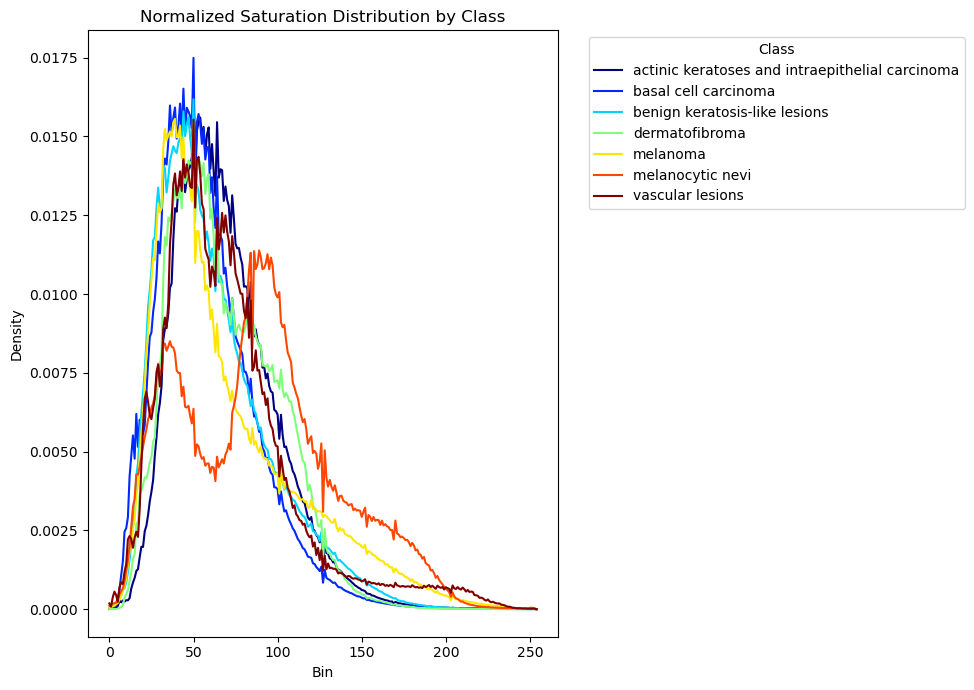

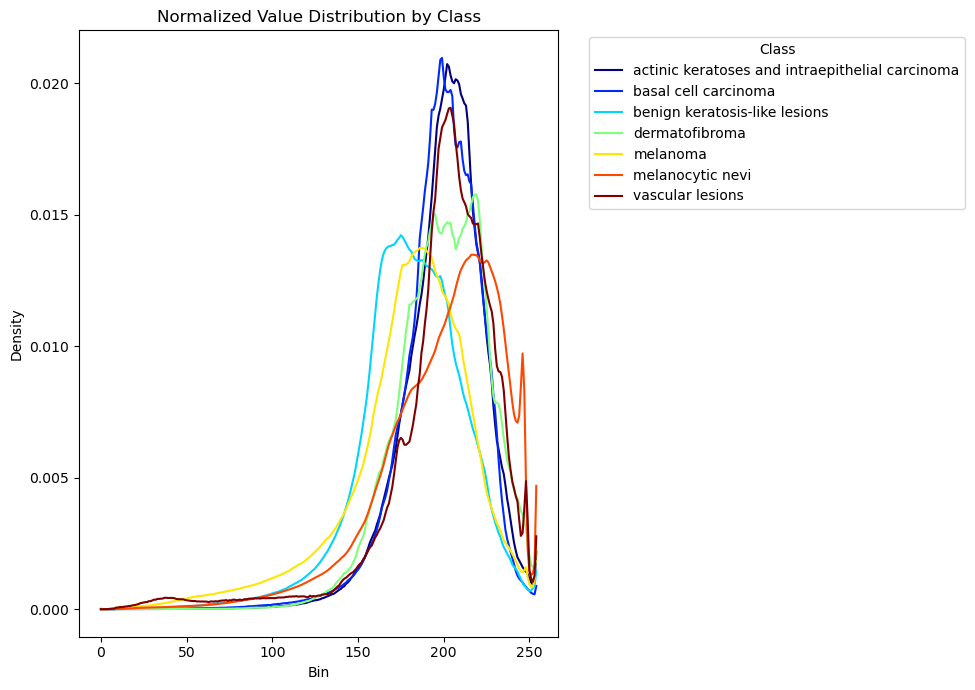

In [193]:
# Plotting normalized HSV histogram for each image

import matplotlib.pyplot as plt


dermamnist_labels = INFO['dermamnist']['label']

def plot_class_histograms(histograms, title, xlabel='Bin', ylabel='Density'):
    plt.figure(figsize=(10, 7))
    colors = plt.cm.jet(np.linspace(0, 1, len(histograms)))
    for class_idx, hist in enumerate(histograms):
        # Use the class index to get the corresponding class name from the dictionary
        class_name = dermamnist_labels[str(class_idx)]
        plt.plot(hist[:-1], label=f'{class_name}', color=colors[class_idx])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    


# Plotting the normalized histograms for Hue, Saturation, and Value
plot_class_histograms(class_hue_hists, 'Normalized Hue Distribution by Class')
plot_class_histograms(class_sat_hists, 'Normalized Saturation Distribution by Class')
plot_class_histograms(class_val_hists, 'Normalized Value Distribution by Class')

In [109]:
train_dataset.montage(length=3)
print(train_dataset)

Dataset DermaMNIST of size 224 (dermamnist_224)
    Number of datapoints: 7007
    Root location: C:\Users\matia\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


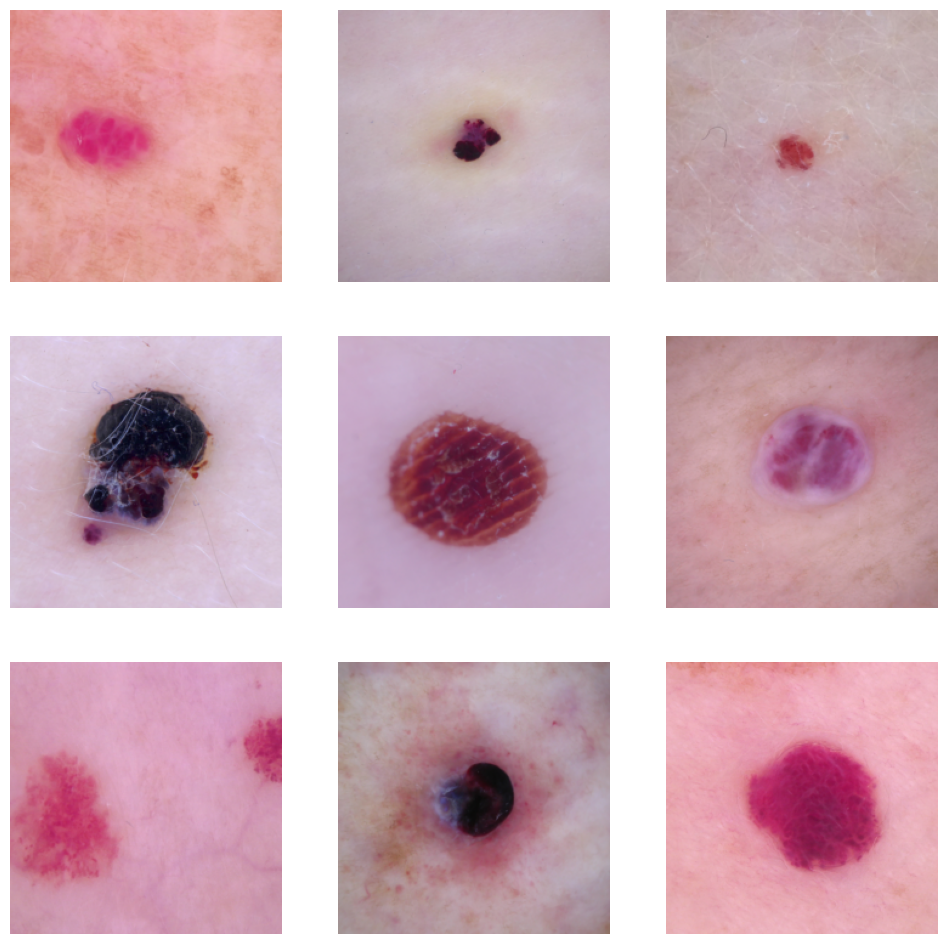

In [165]:
# Plot images from same class to analyze similarities

import matplotlib.pyplot as plt

def show_images_of_class(dataset, class_label, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    count = 0
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == class_label and count < num_images:
            ax = axes[count // 3, count % 3]
            ax.imshow(image.permute(1, 2, 0))  # Adjust for RGB images
            ax.axis('off')
            count += 1
        if count == num_images:
            break
    plt.show()
show_images_of_class(train_dataset, class_label=6)





In [192]:
# Complex feature extraction. Using ResNet18. Need a new transform to make the data compatible with resnet input
"""
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

# Load the dataset
train_dataset_resnet = DataClass(split='train', transform=resnet_transform, download=True, size=224, mmap_mode='r')
train_loader_resnet = data.DataLoader(dataset=train_dataset_resnet, batch_size=BATCH_SIZE, shuffle=True)

x,_ = train_dataset_resnet[0]
print(x)
"""

# Load the pre-trained ResNet model
resnet18 = models.resnet18(pretrained=True)

# Remove the final fully connected layer to use the network as a feature extractor
modules = list(resnet18.children())[:-1]  # Removing the last layer
resnet18 = torch.nn.Sequential(*modules)

# Move model to CPU (remove .cuda() calls if your setup doesn't support CUDA)
resnet18 = resnet18.cpu()

# Set the model to evaluation mode
resnet18.eval()

def resnet18_feature(loader):
    # Placeholder for extracted features and labels
    features = []
    labels = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, targets in tqdm(loader):
            # Extract features
            output_features = resnet18(inputs)

            # Flatten the output features to a 2D array where each row is a feature vector
            output_features = output_features.view(output_features.size(0), -1)

            # Collect the features and labels
            features.append(output_features.numpy())  # Convert features to NumPy array
            labels.append(targets.numpy())

    # Convert the list of arrays to a single 2D array for features and 1D array for labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    print(f'Extracted features shape: {features.shape}')
    print(f'Labels shape: {labels.shape}')
    
    return features, labels

In [194]:
# Do resnet feature extraction with train data
#So there is no preprocess at all
resnet_feature_matrix, labels = resnet18_feature(train_loader)

100%|██████████| 55/55 [03:18<00:00,  3.62s/it]

Extracted features shape: (7007, 512)
Labels shape: (7007, 1)


## Then we train and evaluate on this 224x224 dataset

In [145]:
from torchvision import models, transforms
from torchvision.models import resnet18


resnet18 = models.resnet18(pretrained=True)
print(resnet18)
"""
model = resnet18(num_classes=n_classes).cuda()

criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)"""

C:\Users\matia\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\matia\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\matia/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

'\nmodel = resnet18(num_classes=n_classes).cuda()\n\ncriterion = nn.CrossEntropyLoss()\n    \noptimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)'

In [22]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        targets = targets.cuda()
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 704/704 [02:39<00:00,  4.41it/s]


In [23]:
split = 'test'

model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

test  auc: 0.760  acc: 0.277


In [252]:
# Classifying with logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


X = np.concatenate([hsv_feature_matrix, resnet_feature_matrix], axis=1)

logreg = make_pipeline(
    StandardScaler(),
    PCA(n_components=800),
    LogisticRegression(max_iter=1000, C=0.1)
)


# Fit the model
logreg.fit(X, labels)

# Predict on the training set and test set
y_train_pred = logreg.predict(X)


# Calculate accuracy
train_accuracy = accuracy_score(labels, y_train_pred)


print(f'Training Accuracy: {train_accuracy}')

C:\Users\matia\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.9019551876694734


In [250]:
#Validation

hsv_matrix_val,_,_,_ = hsv_feature(val_dataset)
resnet_matrix_val, labels_val = resnet18_feature(val_loader)

X_val = np.concatenate([hsv_matrix_val, resnet_matrix_val], axis=1)



100%|██████████| 8/8 [00:40<00:00,  5.03s/it]

Extracted features shape: (1003, 512)
Labels shape: (1003, 1)


In [253]:
y_val_pred = logreg.predict(X_val)
val_accuracy = accuracy_score(labels_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')

Validation Accuracy: 0.7666999002991027


In [213]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
print(X_scaled)
print(hsv_feature_matrix)
print(X)
print(resnet_feature_matrix)

(7007, 1280)
[[ 0.09190804  0.1608738  -0.0378861  ... -1.41937826 -0.5919346
  -0.64357229]
 [-0.60261558 -0.24793865  0.10714686 ...  0.44001591 -0.45951652
  -0.64357229]
 [-0.8117861  -0.80397914 -0.83534426 ...  0.1614239   0.85689796
  -0.57129988]
 ...
 [-0.9481343  -0.88592683 -0.84471562 ... -0.64682589 -0.5919346
  -0.61483519]
 [-0.99926487 -0.91277974 -0.86747464 ... -1.0150128  -0.5919346
  -0.64357229]
 [ 0.32160827  0.50301695  0.31688684 ...  0.43874247 -0.57127135
  -0.64357229]]
[[2884 2321 1860 ...    0    0    0]
 [1091 1438 2185 ...    0    0    0]
 [ 551  237   73 ...    0    0    0]
 ...
 [ 199   60   52 ...    0    0    0]
 [  67    2    1 ...    0    0    0]
 [3477 3060 2655 ...    3    1    0]]
[[2.88400000e+03 2.32100000e+03 1.86000000e+03 ... 2.01954946e-01
  0.00000000e+00 0.00000000e+00]
 [1.09100000e+03 1.43800000e+03 2.18500000e+03 ... 1.67834067e+00
  1.53756076e-02 0.00000000e+00]
 [5.51000000e+02 2.37000000e+02 7.30000000e+01 ... 1.45713460e+00
  1.68

# We then check a 3D dataset with size 28x28x28

In [24]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d.npz


In [25]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [26]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [27]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

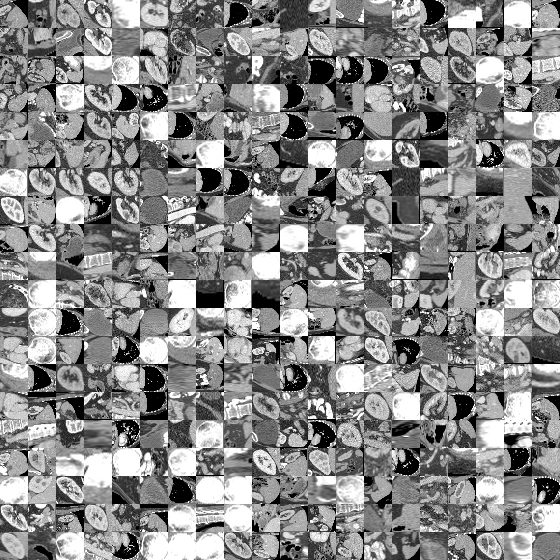

In [28]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# We then check a 3D dataset with size 64x64x64

In [29]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Using downloaded and verified file: /home/sr/.medmnist/organmnist3d_64.npz


In [30]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [31]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


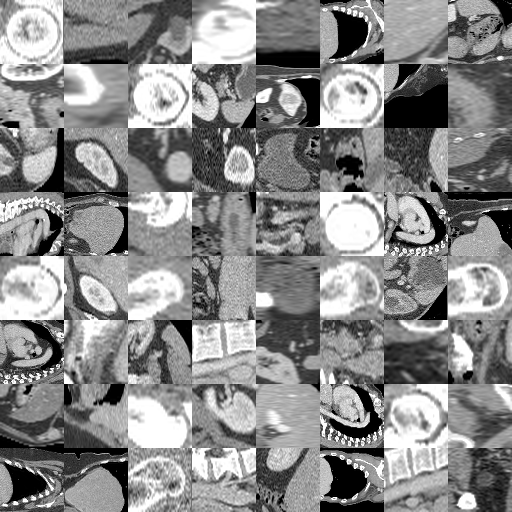

In [32]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)